## WeGaw Data Analysis

This notebook calculates snowpack values from WeGaw remote sensing data. These data are accessed via the Metro Van WeGaw dashboard, and include raster and time series (.csv) data.

* Dashboard: https://dashboard.staging.defrost.io/dashboard
* Username: metrovancouver
* Password: oTCmG6xw$BW#x&

In [1]:
# Import needed libraries
import rasterio 
import rasterio.mask 
import geopandas as gpd 
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

ImportError: DLL load failed while importing _warp: The specified procedure could not be found.

In [2]:
# Set you working directory. This is the folder where the data files are found. 
# Inside the Snow Survey Report folder, there is a Data folder, which has a rasters folder and a watersheds folder
os.chdir('C://Users/pmarshal/Documents/swe_analysis')
os.getcwd()

'C:\\Users\\pmarshal\\Documents\\swe_analysis'

In [3]:
import sys
sys.path.append("./src")

from swe_processing import stored_water_by_elev_band

In [4]:
# Desired elevation bands
bands = {
    "150–800 m": (150, 800),
    "800–1000 m": (800, 1000),
    "1000–1200 m": (1000, 1200),
    ">1200 m": (1200, None),
}

In [5]:

# Apply to watersheds. You can change the swe_path to seymour_swe_yyyy-mm-dd as needed
swe_path = "data/rasters/capilano_swe_2026-02-15.tif"
dem_path = "config/dem10m.tif"

band_results = stored_water_by_elev_band(swe_path, dem_path, bands)
# Convert dict → DataFrame
df_results = pd.DataFrame(
    list(band_results.items()),
    columns=["Elevation Band", "Stored Water (BL)"]
)

# Add total row
total_bl = df_results["Stored Water (BL)"].sum()
df_results.loc[len(df_results)] = ["Total", total_bl]

# Round for readability
df_results["Stored Water (BL)"] = df_results["Stored Water (BL)"].round(2)

print(df_results.to_string(index=False))


Elevation Band  Stored Water (BL)
     150–800 m               0.00
    800–1000 m               2.50
   1000–1200 m              16.28
       >1200 m              22.48
         Total              41.27


## WeGaw basin averaged SWE time series plots

In [38]:
# Import wegaw time series data
wegaw_df = pd.read_csv('data/timeseries/wegaw_swe.csv', parse_dates=['date']) 
wegaw_df['cap_swe_mm'] = wegaw_df['cap_swe'] * 10
wegaw_df['sey_swe_mm'] = wegaw_df['sey_swe'] * 10

# view the last 5 entries
#wegaw_df.tail(5)

In [39]:
# Copy time series
df = wegaw_df.copy()

# Assign water year
df['wy'] = df['date'].dt.year
df.loc[df['date'].dt.month >= 10, 'wy'] += 1

# Water-year start date
df['wy_start'] = pd.to_datetime(df['wy'] - 1, format='%Y') + pd.Timedelta(days=273)

# Day of water year
df['dowy'] = (df['date'] - df['wy_start']).dt.days + 1

In [7]:
# Create refence start date for plotting
ref_start = pd.Timestamp("2000-10-01")
df['plot_date'] = ref_start + pd.to_timedelta(df['dowy'] - 1, unit='D')


In [8]:
start = pd.Timestamp("2000-10-01")
end   = pd.Timestamp("2001-08-01")

df = df[(df['plot_date'] >= start) & (df['plot_date'] <= end)]

In [13]:
# Select current and past years and calculate historical data
current_wy = 2026
previous_wys = [2025, 2024]

hist = df[df['wy'] != current_wy]
# For Seymour, change cap_swe_mm to sey_swe_mm
clim = (
    hist.groupby('dowy')['cap_swe_mm']
        .agg([
            ('p05', lambda x: np.percentile(x, 5)),
            ('p25', lambda x: np.percentile(x, 25)),
            ('mean', 'mean'),
            ('p75', lambda x: np.percentile(x, 75)),
            ('p95', lambda x: np.percentile(x, 95)),
        ])
        .reset_index()
)

clim['plot_date'] = ref_start + pd.to_timedelta(clim['dowy'] - 1, unit='D')

In [14]:
df_sel = df[df['wy'].isin([current_wy] + previous_wys)]

In [54]:
# Import libraries for time series data viewing
import altair as alt
import altair_saver 

# Create plot. For Seymour, change title and cap_swe_mm 
title = alt.TitleParams(
   text='Capilano Watershed – Basin Average Snow Water Equivalent',
   subtitle="SWE Estimate from WeGaw Remote Sensing",
   anchor='middle',
   fontSize=14,
   fontWeight='bold'
)

base = alt.Chart().encode(
    x=alt.X('plot_date:T', title='', axis=alt.Axis(format='%b'))
)

# 5–95% band
band_5_95 = alt.Chart(clim).mark_area(opacity=0.3, color='#c6dbef').encode(
    x=alt.X('plot_date:T', title=None),
    y=alt.Y('p05:Q', title='Snow Water Equivalent (mm)'),
    y2='p95:Q'
)

# 25–75% band
band_25_75 = alt.Chart(clim).mark_area(opacity=0.5, color='#6baed6').encode(
    x='plot_date:T',
    y='p25:Q',
    y2='p75:Q'
)

# Historical mean
mean_line = alt.Chart(clim).mark_line(color='gray', strokeDash=[4,4]).encode(
    x='plot_date:T',
    y='mean:Q'
)

# Lines for 2024, 2025, 2026
base_lines = (
    alt.Chart(df_sel)
    .mark_line(size=1.5, opacity=0.6)
    .encode(
        x='plot_date:T',
        y='cap_swe_mm:Q',
        color=alt.Color('wy:N', title='Season',
                        scale=alt.Scale(
                            domain=[2024, 2025, 2026],
                            range=['#44e7f4', '#0b6aa3', '#2d4668']
                        ))
    )
)

current_line = (
    alt.Chart(df_sel[df_sel['wy'] == 2026])
    .mark_line(size=2.5, opacity=1.0, color='#2d4668')
    .encode(
        x='plot_date:T',
        y='cap_swe_mm:Q'
    )
)

chart = (band_5_95 + band_25_75 + mean_line + base_lines + current_line).properties(
    width=600,
    height=300,
    title=title
)

chart

alt.LayerChart(...)

In [135]:
chart.save("wegaw_ts_chart.png", scale_factor=3.0)

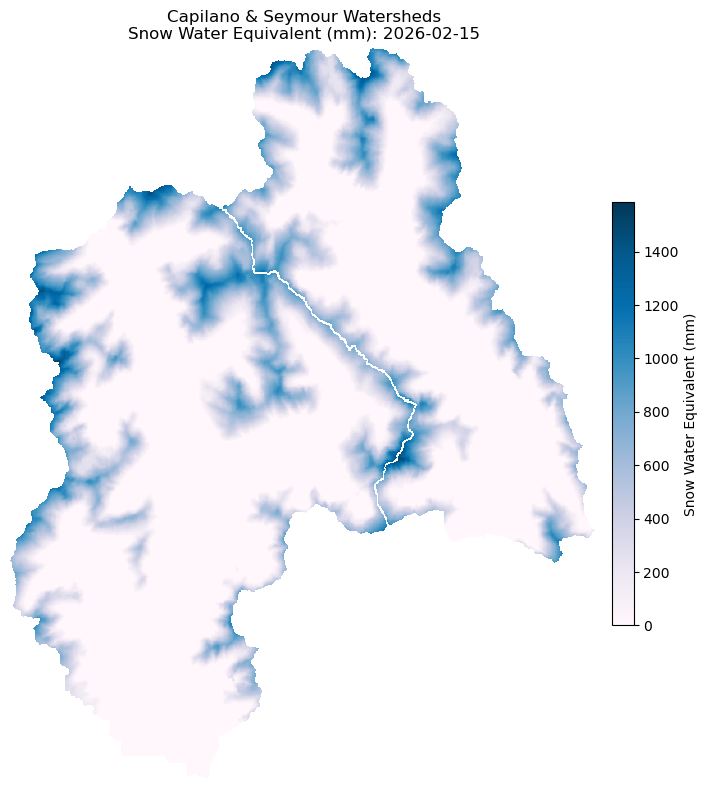

In [107]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# --- File paths ---
cap_file = "data/rasters/capilano_swe_2026-02-15.tif"
seym_file = "data/rasters/seymour_swe_2026-02-15.tif"

cap_data = cap.read(1)
seym_data = seym.read(1)

cap_data = np.where(cap_data == cap.nodata, np.nan, cap_data)
seym_data = np.where(seym_data == seym.nodata, np.nan, seym_data)

vmin = 0
vmax = max(np.nanmax(cap_data), np.nanmax(seym_data))

fig, ax = plt.subplots(figsize=(8, 8))

# Plot both rasters
show(cap_data, transform=cap.transform, ax=ax, cmap="PuBu", vmin=vmin, vmax=vmax)
show(seym_data, transform=seym.transform, ax=ax, cmap="PuBu", vmin=vmin, vmax=vmax)

# --- FIX: compute combined extent ---
cap_bounds = cap.bounds
seym_bounds = seym.bounds

minx = min(cap_bounds.left, seym_bounds.left)
maxx = max(cap_bounds.right, seym_bounds.right)
miny = min(cap_bounds.bottom, seym_bounds.bottom)
maxy = max(cap_bounds.top, seym_bounds.top)

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Colorbar
sm = plt.cm.ScalarMappable(cmap="PuBu", norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("Snow Water Equivalent (mm)")

ax.set_title("Capilano & Seymour Watersheds\nSnow Water Equivalent: 2026‑02‑15")
ax.set_axis_off()

plt.tight_layout()
plt.savefig("swe_map.png", dpi=300, bbox_inches="tight")
plt.show()


### Calculate stats from the time series data
* Current basin-average SWE
* Percent of normal
* Current percentile

In [55]:
current_wy = 2026

current_row = (
    df_sel[df_sel['wy'] == current_wy]
    .sort_values('plot_date')
    .tail(1)
)

current_swe = float(current_row['cap_swe_mm'])
current_dowy = int(current_row['dowy'])


In [56]:
hist_values = df[df['wy'] < current_wy]
hist_values = hist_values[hist_values['dowy'] == current_dowy]['cap_swe_mm'].dropna()


In [61]:
from scipy.stats import percentileofscore

current_percentile = percentileofscore(hist_values, current_swe)

In [59]:
hist_mean = float(clim.loc[clim['dowy'] == current_dowy, 'mean'])
percent_of_normal = (current_swe / hist_mean) * 100

In [60]:
print(f"Current SWE: {current_swe:.1f} mm")
print(f"Percentile: {current_percentile:.1f}")
print(f"Percent of normal: {percent_of_normal:.1f}%")


Current SWE: 209.7 mm
Percentile: 14.3
Percent of normal: 39.6%
